In [1]:
!pip install sacrebleu
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from collections import Counter
import csv
import sacrebleu
import numpy as np
from sklearn.metrics import make_scorer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5.2 MB/s eta 0:00:00


In [2]:
# Load JSON dataset (using UTF-8 encoding)
with open('/content/Arabic.json', encoding='utf-8') as f:
    arabic_data = json.load(f)

# Convert data into parallel pairs (first 100 rows for simplicity)
arabic_sentences = [entry['output'] for entry in arabic_data[:1000]]
en_sentences = [entry['input'] for entry in arabic_data[:1000]]

# Tokenize sentences (basic whitespace-based tokenization)
def tokenize(sentences):
    return [sentence.split() for sentence in sentences]

# Tokenize English and Arabic sentences
en_tokens = tokenize(en_sentences)
arabic_tokens = tokenize(arabic_sentences)

# Create vocabularies with special tokens
vocab_en = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
vocab_arabic = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}

# Update vocabulary from tokens
vocab_en.update({word: idx + 4 for idx, (word, _) in enumerate(Counter([token for sentence in en_tokens for token in sentence]).items())})
vocab_arabic.update({word: idx + 4 for idx, (word, _) in enumerate(Counter([token for sentence in arabic_tokens for token in sentence]).items())})

# Model parameters
input_dim = len(vocab_en)
output_dim = len(vocab_arabic)
emb_dim = 256
hidden_dim = 512
n_layers = 2
dropout = 0.5

In [3]:

# Define Seq2Seq Model (Encoder-Decoder architecture)
class Seq2Seq(nn.Module):
    def __init__(self, source_vocab, target_vocab, embedding_dim, hidden_dim, dropout=0.1):
        super(Seq2Seq, self).__init__()

        # Define embedding layers
        self.embedding_src = nn.Embedding(len(source_vocab), embedding_dim)
        self.embedding_trg = nn.Embedding(len(target_vocab), embedding_dim)

        # Encoder and Decoder setup
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Output fully connected layer
        self.fc_out = nn.Linear(hidden_dim, len(target_vocab))

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, trg):
        # Embed source and target sequences
        embedded_src = self.dropout(self.embedding_src(src))
        embedded_trg = self.dropout(self.embedding_trg(trg))

        # Pass source sequence through encoder
        _, (hidden, cell) = self.encoder(embedded_src)

        # Pass target sequence through decoder
        output, _ = self.decoder(embedded_trg, (hidden, cell))

        # Output from fully connected layer
        output = self.fc_out(output)
        return output

In [4]:
# Initialize weights
def initialize_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            nn.init.xavier_uniform_(param)
        else:
            nn.init.zeros_(param)

# Define Dataset and DataLoader
class ParallelDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, source_vocab, target_vocab):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

        # Ensure special tokens are added to vocabularies
        special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
        for token in special_tokens:
            if token not in self.source_vocab:
                self.source_vocab[token] = len(self.source_vocab)
            if token not in self.target_vocab:
                self.target_vocab[token] = len(self.target_vocab)

        # Set max index to prevent index errors
        self.source_max_idx = len(self.source_vocab) - 1
        self.target_max_idx = len(self.target_vocab) - 1

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        # Convert source sentence to indices, handling unknown tokens
        source_indices = [
            min(self.source_vocab.get(word, self.source_vocab['<unk>']), self.source_max_idx)
            for word in self.source_sentences[idx].split()
        ]
        target_indices = [
            min(self.target_vocab.get(word, self.target_vocab['<unk>']), self.target_max_idx)
            for word in self.target_sentences[idx].split()
        ]

        # Adding <sos> and <eos> tokens
        source_indices = [self.source_vocab['<sos>']] + source_indices + [self.source_vocab['<eos>']]
        target_indices = [self.target_vocab['<sos>']] + target_indices + [self.target_vocab['<eos>']]

        # Convert to tensors
        source_tensor = torch.tensor(source_indices, dtype=torch.long)
        target_tensor = torch.tensor(target_indices, dtype=torch.long)

        return source_tensor, target_tensor

In [5]:
# Collate function for padding sequences
def collate_fn(batch):
    source_sentences, target_sentences = zip(*batch)
    source_padded = pad_sequence(source_sentences, padding_value=0, batch_first=True)
    target_padded = pad_sequence(target_sentences, padding_value=0, batch_first=True)
    return source_padded, target_padded

# Hyperparameters
batch_size = 8
epochs = 10
clip = 1

# DataLoader initialization
train_data = ParallelDataset(en_sentences, arabic_sentences, vocab_en, vocab_arabic)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Model, optimizer, and criterion
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(vocab_en, vocab_arabic, emb_dim, hidden_dim, dropout).to(device)
model.apply(initialize_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_arabic['<pad>'])

In [6]:
# Training loop with validation
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    for source, target in train_loader:
        source, target = source.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(source, target)
        output = output.view(-1, output_dim)
        target = target.view(-1)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for source, target in val_loader:
            source, target = source.to(device), target.to(device)
            output = model(source, target)
            output = output.view(-1, output_dim)
            target = target.view(-1)
            loss = criterion(output, target)
            val_loss += loss.item()
    return val_loss / len(val_loader)
# Train the model
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    # Append the losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Save the model
torch.save(model.state_dict(), 'seq2seq_model.pth')

Epoch [1/10], Train Loss: 7.9904, Val Loss: 7.1785
Epoch [2/10], Train Loss: 6.7035, Val Loss: 6.7906
Epoch [3/10], Train Loss: 6.0397, Val Loss: 6.6719
Epoch [4/10], Train Loss: 5.4982, Val Loss: 6.6486
Epoch [5/10], Train Loss: 4.8510, Val Loss: 6.5560
Epoch [6/10], Train Loss: 4.1880, Val Loss: 6.4443
Epoch [7/10], Train Loss: 3.5064, Val Loss: 6.4138
Epoch [8/10], Train Loss: 2.7989, Val Loss: 6.3994
Epoch [9/10], Train Loss: 2.1616, Val Loss: 6.3504
Epoch [10/10], Train Loss: 1.6126, Val Loss: 6.3858


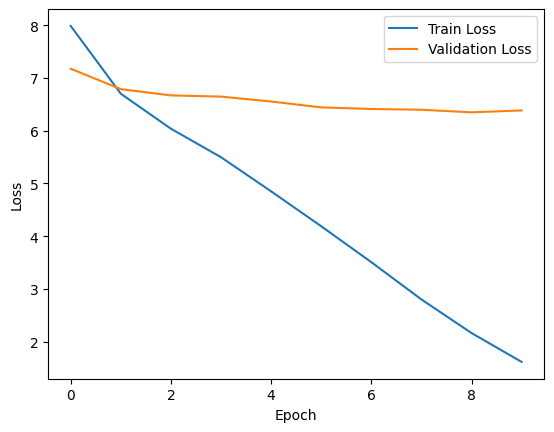

In [7]:
# Save training and validation losses to CSV
import pandas as pd
loss_data = pd.DataFrame({"epoch": list(range(1, epochs+1)), "train_loss": train_losses, "val_loss": val_losses})
loss_data.to_csv("train_val_losses.csv", index=False)

# Plotting the losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [8]:
# Translate a test sentence
def translate_sentence(model, sentence, vocab_en, vocab_arabic):
    model.eval()
    with torch.no_grad():
        test_indices = [vocab_en.get(word, vocab_en['<unk>']) for word in sentence.split()]
        test_indices = [vocab_en['<sos>']] + test_indices + [vocab_en['<eos>']]
        test_tensor = torch.tensor(test_indices, dtype=torch.long).unsqueeze(0).to(device)

        output = model(test_tensor, test_tensor)
        output_indices = output.argmax(dim=-1).squeeze(0).cpu().numpy().tolist()

        translated_sentence = ' '.join([list(vocab_arabic.keys())[list(vocab_arabic.values()).index(idx)] for idx in output_indices])
        return translated_sentence

# Test translation
test_sentence = "this is a test sentence"
translated_sentence = translate_sentence(model, test_sentence, vocab_en, vocab_arabic)
print(f"Original: {test_sentence}")
print(f"Translated: {translated_sentence}")

Original: this is a test sentence
Translated: <sos> قارن نظامًا بفرح منفردا. الاستراحات <eos>


In [9]:
# Compute BLEU and CHRF scores and save to CSV
def compute_bleu_chrf_per_sentence(model, val_loader, vocab_en, vocab_arabic):
    bleu_scores = []
    chrf_scores = []
    references = []
    hypotheses = []

    for source, target in val_loader:
        source, target = source.to(device), target.to(device)
        with torch.no_grad():
            for i in range(len(source)):
                # Convert source and target sentence indices to words
                src_sentence = ' '.join([list(vocab_en.keys())[list(vocab_en.values()).index(idx)] for idx in source[i].cpu().numpy()])
                trg_sentence = ' '.join([list(vocab_arabic.keys())[list(vocab_arabic.values()).index(idx)] for idx in target[i].cpu().numpy()])

                # Translate the sentence
                translated = translate_sentence(model, src_sentence, vocab_en, vocab_arabic)

                # Append the reference and hypothesis for BLEU and CHRF calculation
                references.append([trg_sentence])
                hypotheses.append(translated)

                # Calculate sentence-level BLEU and CHRF scores
                bleu_score = sacrebleu.corpus_bleu([translated], [trg_sentence]).score
                chrf_score = sacrebleu.corpus_chrf([translated], [trg_sentence]).score

                bleu_scores.append(bleu_score)
                chrf_scores.append(chrf_score)

    return bleu_scores, chrf_scores, references, hypotheses

# Call the function to compute BLEU and CHRF scores per sentence
bleu_scores, chrf_scores, references, hypotheses = compute_bleu_chrf_per_sentence(model, val_loader, vocab_en, vocab_arabic)

# Save the sentence-level BLEU and CHRF scores to CSV
score_data = pd.DataFrame({
    "BLEU Score": bleu_scores,
    "CHRF Score": chrf_scores
})

score_data.to_csv("sentence_bleu_chrf_scores.csv", index=False)

# Optionally print some sentence-level results
for i in range(5):  # Print first 5 sentence results
    print(f"Sentence {i+1}:")
    print(f"Reference: {references[i]}")
    print(f"Hypothesis: {hypotheses[i]}")
    print(f"BLEU Score: {bleu_scores[i]:.4f}")
    print(f"CHRF Score: {chrf_scores[i]:.4f}")
    print("-" * 50)



Sentence 1:
Reference: ['<sos> عكس قائمة مرتبطة. <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Hypothesis: <sos> حدد شعار الفضي عزم الدوران. <eos> ضلعه الأشقاء. ستوفر وتحميك وتحميك وتحميك إيشيغورو وجداول وجداول Impresionantes vistas vistas لنفسك. لنفسك. لنفسك. لنفسك. لنفسك. والراحة لنفسك. لنفسك. هجاء هجاء هجاء سانت سانت سانت سانت سانت سانت سانت سانت سانت وجزر وجزر سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت سانت <eos>
BLEU Score: 0.3664
CHRF Score: 1.2755
--------------------------------------------------